I am following the notebook [here](https://huggingface.co/learn/cookbook/rag_evaluation). I will replace the calls to the OpenAI models with calls to the models from Groq. Also, I will use `Haystack` instad of `LangChain`.

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [2]:
import glob

pdffiles = []
for file in glob.glob("./papers_for_RAG/*.pdf"):
    pdffiles.append(file)

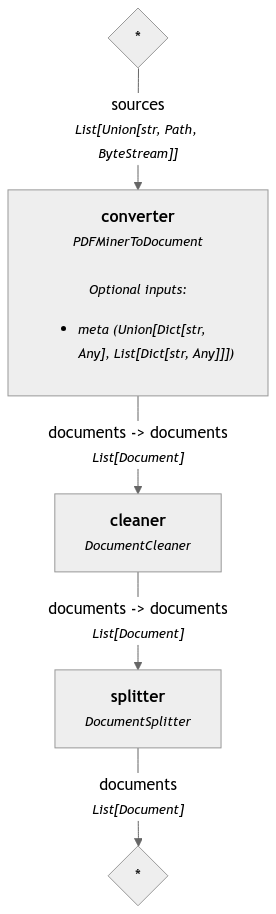

In [3]:
from haystack import Pipeline
from haystack.components.converters import PDFMinerToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter

# initialize the pipeline to split documents into chunks
chunking_pipeline = Pipeline()

# add the different components
chunking_pipeline.add_component("converter", PDFMinerToDocument())
chunking_pipeline.add_component("cleaner", DocumentCleaner(ascii_only=True,
	remove_empty_lines=True,
	remove_extra_whitespaces=True,
	remove_repeated_substrings=False))
chunking_pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=5))

# connect each component to the next one
chunking_pipeline.connect("converter", "cleaner")
chunking_pipeline.connect("cleaner", "splitter")

# view the pipeline
chunking_pipeline.show()


In [4]:
# run the indexing pipeline over the pdf docs
splitted_docs = chunking_pipeline.run({"converter": {"sources": pdffiles}})

In [5]:
# check how a chunk looks like
print(splitted_docs["splitter"]["documents"][10].content)

 The ability to identify single nucleotide variants (SNVs) and
somatic copy number alterations (SCNAs) in cfDNA might overcome the challenges faced by
detection of these alterations using whole genome sequencing in tumor samples due to cost
and storage of the data generated. In addition, genomic analyses in cfDNA can improve tumor
molecular classification at diagnosis and support the selection of tailored treatments [22, 23].
Several groups have evaluated the use of shallow whole-genome sequencing (sWGS) to identify
SCNAs in several tumors including BC as a less expensive alternative [24, 25]. sWGS is a high-
throughput technology that provides a cost-effective and accurate method to achieve genome-
wide genetic variation with very low coverage (most frequently between 0.4x and 1x) [26].


In [23]:
splitted_docs_list = [doc.content for doc in splitted_docs["splitter"]["documents"]]
splitted_docs_meta_list = [doc.meta for doc in splitted_docs["splitter"]["documents"]]

In [7]:
# initialize the llm
from haystack.components.generators import OpenAIGenerator
from haystack.utils import Secret

llm = OpenAIGenerator(
    api_key=Secret.from_env_var("GROQ_API_KEY"),
    api_base_url="https://api.groq.com/openai/v1",
    model="llama-3.1-8b-instant",
    generation_kwargs = {"max_tokens": 512, "seed": 42}
)

In [8]:
# initialize the pipeline
qa_pipeline = Pipeline()

In [9]:
from haystack.components.builders import PromptBuilder

# write the QA prompt
QA_generation_prompt = """
# Task
Your task is to write a factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question should be formulated in the same style as questions users could ask in a search engine.
This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

# Output
Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

# Example
Context: We evaluated the feasibility to detect somatic copy number alterations (SCNAs) in BC
using shallow whole genome sequencing (sWGS) in cfDNA from archived samples from
National Cancer Institute of Colombia patients. We sequenced tumor tissues from 38 BC
patients with different molecular subtypes using a gene panel of 176 genes significantly
mutated in cancer, and by liquid biopsies using sWGS on 20 paired samples to detect
SCNAs and compare with the tumor samples. We identified an extensive intertumoral het-
erogeneity between the molecular subtypes of BC, with a mean tumor load of 602 mutations
in the gene panel of tumor tissues. There was a 12.3% of concordance in deletions in the
cfDNA-tumor pairs considering only the genes covered by the panel encompassing seven
genes: BRCA1, CDK12, NF1, MAP2K4, NCOR1, TP53, and KEAP1 in three patients.

Factoid question: What was the concordance ratio in deletions in the cfDNA-tumor pairs?

Answer: There was a 12.3% of concordance. 

Now here is the context.

Context: {{context}}\n
Output:::"""

prompt_builder = PromptBuilder(template=QA_generation_prompt)

qa_pipeline.add_component("prompt", prompt_builder)
qa_pipeline.add_component("llm", llm)

qa_pipeline.connect("prompt.prompt", "llm.prompt")

🚅 Components
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt.prompt -> llm.prompt (str)

In [10]:
# try the pipeline on an example
result = qa_pipeline.run({"prompt": {"context": splitted_docs_list[10]}})
print(result["llm"]["replies"][0])

Factoid question: What is the typical coverage of shallow whole-genome sequencing (sWGS)?
Answer: A coverage of most frequently between 0.4x and 1x.


In [48]:
# run the pipeline to generate QA pairs from the chunks
import random
from tqdm.auto import tqdm

N_GENERATIONS = 10  # We intentionally generate only 10 QA couples here for cost and time considerations

print(f"Generating {N_GENERATIONS} QA couples...")

outputs = []
random.seed(42)
for idx, sampled_context in enumerate(tqdm(random.sample(splitted_docs_list, N_GENERATIONS))):
    # Generate QA couple
    output_QA_couple = qa_pipeline.run({"prompt": {"context": sampled_context}})
    try:
        question = output_QA_couple["llm"]["replies"][0].split("Factoid question: ")[-1].split("Answer: ")[0]
        answer = output_QA_couple["llm"]["replies"][0].split("Answer: ")[-1]
        assert len(answer) < 300, "Answer is too long"
        outputs.append(
            {
                "context": sampled_context,
                "question": question,
                "answer": answer,
                "source_doc": splitted_docs_meta_list[idx]["file_path"],
            }
        )
    except:
        print("there was a problem parsing the llm answer.")
        continue

Generating 10 QA couples...


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


In [49]:
outputs

[{'context': ' Radiomics signature coefficients for prediction of recurrence. (A) Box plot shows selected features coefficients sorted by descending order of selection\nratio over splits. (B) Count plot of radiomics signature coefficients selections over the splits for the aggregation the radiomics signature coefficients with the\naggregation largest lesion only.\nhttps://doi.org/10.',
  'question': 'What is shown in plot (B)?\n\n',
  'answer': 'Plot (B) shows the count of radiomics signature coefficients selections over the splits.',
  'source_doc': './papers_for_RAG/journal.pone.0308176.pdf'},
 {'context': ' Scully OJ, Bay BH, Yip G, Yu Y. Breast cancer metastasis. Cancer genomics & proteomics. 2012;\n9(5):311320. PMID: 22990110\n8.',
  'question': 'What is the title of the article where breast cancer metastasis is discussed?\n',
  'answer': 'Breast cancer metastasis.',
  'source_doc': './papers_for_RAG/journal.pone.0308176.pdf'},
 {'context': ' Regions with a depth <10X were exclude